# Deep Q Learning pour Breakout d'Atari: **train script**

Dans ce notebook, on implémente l'entraînement d'un agent de Deep Q-Learning (DQN) pour jouer au jeu Breakout d'Atari. 
Pour cela, on utilise les bibliothèques Keras-rl, TensorFlow et Gymnasium pour construire l'environnement d'entraînement et entraîner l'agent.

Rq: pour avoir les jeux Atari dans gymnasium utiliser `pip install gymnasium[atari]`

## 1. Configuration de l'environnement

Importation des différentes bibliothèques nécessaires

In [1]:
import keras
import gymnasium as gym
from gymnasium.wrappers import FrameStack, AtariPreprocessing
from keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Permute
import matplotlib.pyplot as plt
import numpy as np
import pickle

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.util import *
from rl.core import Processor

C:\Users\33626\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


On définit ensuite les paramètres contrôlant les divers aspects de l'apprentissage (notamment le taux d'exploration epsilon), le facteur de réduction des récompenses (gamma), la taille des batch pour l'apprentissage, le nombre maximums d'épisodes ou d'étapes dans les épisodes.

In [2]:
# Paramètres de configuration
seed = 42
gamma = 0.99  # Facteur de réduction pour les récompenses futures
epsilon = 1.0  # Paramètre epsilon-greedy
epsilon_min = 0.1  # Valeur minimale d'epsilon
epsilon_max = 1.0  # Valeur maximale d'epsilon
epsilon_interval = epsilon_max - epsilon_min
batch_size = 32  # Taille du batch pour l'apprentissage
max_steps_per_episode = 10000
max_episodes = 10  # Limite le nombre d'épisodes d'entraînement

## 2. Préparation des données

Dans cette partie, on définit une class `CompatibilityWrapper` qui sert d'interface entre les différentes versions de l'API Gymnasium. La bibliothèque `Keras-rl` a été conçue pour fonctionner avec l'ancienne version de l'API Gym, elle attend donc une certaine forme de l'environnement.
Les changements dans l'API Gymnasium concernent essentiellement les méthodes `step()` et `reset()`.

* Différence dans la méthode `step()` :

    - Ancienne version : `observation, reward, done, info = env.step(action)`
    - Nouvelle version : `observation, reward, terminated, truncated, info = env.step(action)`

Le `CompatibilityWrapper` combine terminated et truncated en un seul booléen done, ce qui correspond à l'ancien format.

* Différence dans la méthode `reset()` :

    - Ancienne version : `observation = env.reset()`
    - Nouvelle version : `observation, info = env.reset()`

In [3]:
class CompatibilityWrapper(gym.Wrapper):
    def step(self, action):
        # Appelle la méthode step de l'environnement sous-jacent
        observation, reward, terminated, truncated, info = self.env.step(action)
        # Combine terminated et truncated en un seul booléen 'done'
        done = terminated or truncated
        # Retourne le format attendu par l'ancien API
        return observation, reward, done, info

    def reset(self, **kwargs):
        # Appelle la méthode reset de l'environnement sous-jacent
        observation, info = self.env.reset(**kwargs)
        # Ne renvoie que l'observation pour correspondre à l'ancien format
        return observation

In [4]:
# function pour la création de l'environnement
def create_atari_environment(env_name, num_stack=4):
    env = gym.make(env_name, render_mode='rgb_array')
    env = AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30)
    env = CompatibilityWrapper(env)
    return env

Shape of stacked observation: (84, 84)
Type of observation: <class 'numpy.ndarray'>


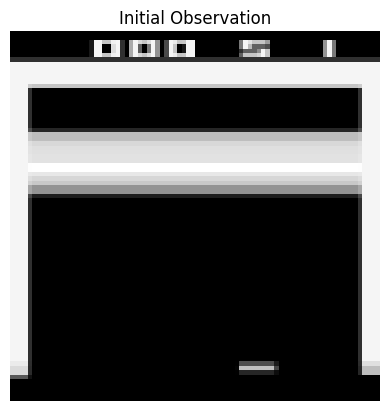

In [5]:
# Créer l'environnement
env = create_atari_environment('ALE/Breakout-v5')

# Réinitialiser l'environnement
observation = env.reset()

print(f"Shape of stacked observation: {observation.shape}")
print(f"Type of observation: {type(observation)}")

# Visualiser une frame
plt.imshow(observation, cmap='gray')
plt.title("Initial Observation")
plt.axis('off')
plt.show()

nb_actions = env.action_space.n

### Pretaitement des observations

`AtariPreprocessing`est un wrapper fourni par Gymnasium pour appliquer un prétraitement commun aux environnement des jeux de type Atari. Il permet de réduire la complexité de l'entrée et d'accélérer l'apprentissage des agents.

`env = AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30)`

* **Redimensionnement de l'image (screen_size=84)** : réduction de l'image à 84x84 pixels.
Objectif : Diminuer la complexité de l'entrée tout en conservant les informations essentielles.
* **Conversion en niveaux de gris (grayscale_obs=True)** : conversion de l'image RGB en niveaux de gris.
Objectif : Réduire la dimensionnalité de l'entrée (de 3 canaux à 1) sans perdre d'informations cruciales pour le jeu.
* **Saut de frames (frame_skip=1)** : Détermine combien de frames sont sautées entre chaque action.
Ici, réglé à 1, ce qui signifie qu'aucune frame n'est sautée.
Objectif : Peut être augmenté pour accélérer l'apprentissage en réduisant la fréquence des décisions.
* **Actions "no-op" au début (noop_max=30)** : Applique un nombre aléatoire (jusqu'à 30) d'actions "no-op" au début de chaque épisode.
Objectif : Introduire de la variabilité dans les conditions initiales pour une meilleure généralisation.

`AtariProcessor`est une classe personnalisée qui hérite de Processor de keras-rl. Elle effectue des traitements supplémentaires pour les observations, les états et les récompenses.


In [6]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        # gère le cas où l'observation est un tuple
        if isinstance(observation, tuple):
            observation = observation[0]
        img = np.array(observation)
        img = img.astype('uint8')
        return img

    def process_state_batch(self, batch):
        # conversion et normalisation des valeurs entre 0 et 1 pour l'entrée dans le réseau de neurones
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        # pour stabiliser l'apprentissage en éviant les grandes variations de récompenses
        return np.clip(reward, -1., 1.)

Rq : Importance du prétraitement des données dans le Deep Q learning
* **Réduction de la complexité** : En réduisant la taille et la dimensionnalité des images, on diminue la complexité du problème d'apprentissage.
* **Stabilité de l'apprentissage** : La normalisation des entrées et le clipping des récompenses aident à stabiliser le processus d'apprentissage.
* **Généralisation** : L'introduction de variabilité (comme les actions no-op) aide l'agent à mieux généraliser.
* **Efficacité computationnelle** : Des entrées plus petites et plus simples permettent un apprentissage plus rapide et moins gourmand en ressources.
* **Cohérence des données** : Assure que les données fournies au réseau neuronal sont toujours dans un format cohérent et approprié.

# 4. Construction du modèle

- **Entrée** : état (une séquence d'images de jeu)
- **Sortie**: les valeurs Q estimées pour chaque action possible
- **Architecture** inspirée de l'[article original](http://arxiv.org/abs/1312.5602) (Mnih et al. 2015)

Détails de l'architecture:
* Les couches convolutionnelles permettent d'extraire les caractéristiques spatiales importantes de l'image du jeu comme la position de la balle, de la raquette et des briques
* On réduit progressivement la dimension : les strides réduisent progressivement la dimension spatiale tout en augmentant le nombre de filtres, le réseau va donc capture des caractéristiques de plus en plus abstraites.
* Les couches denses finales vont permettre de combiner les caractéristiques extraites pour estimer les valeurs Q pour chaque action.
* Activation ReLU: dans toutes les couches sauf la dernière, elle introduit la non linéarité et aide à l'apprentissage de représentations complexes.
* Sortie linéaire : prédiction des valeurs Q sans restriction de plage.

In [7]:
def build_model(window_length, shape, actions):
    model = Sequential()
    # réorganise les dimensions d'entrée en (h,w,window_length)
    model.add(Permute((2, 3, 1), input_shape=(window_length,) + shape))
    model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu'))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

# entrée = sequence de 4 frames consécutives
window_length = 4
model = build_model(window_length, observation.shape, nb_actions)


## 4. Définition de l'Agent DQN

### Memoire Séquentielle
Utilisation d'une mémoire séquentielle pour stocker les expériences des agents
Elle va stocker jusqu'à 1 million d'expériences
Elle utilisera le nombre de frames consécutives définies ultérieurement



In [8]:
# Define sequential memory to store agent's experience
memory = SequentialMemory(limit=1000000,
                          window_length=window_length)

### Prétraitement des observations, des états et des récompenses
Processeur Atari défini et ajusté pour les besoins.



In [9]:
# Define processor to preprocess obs, states and reward
processor = AtariProcessor()

### Politique d'exploration

On définit une politique epsilon-greedy avec décroissance linéaire.
Elle commence avec une exploration maximale (eps=1) et décroie progressivement de 0.1 sur 1 million d'étapes

In [10]:
# Define an epsilon-greedy policy with linear annealing
# for exploration-exploitation trade-off
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr='eps',
                              value_max=1.,
                              value_min=.1,
                              value_test=.05,
                              nb_steps=1000000)

#### Définition de l'agent DQN

* `model`: réseau de neurone défini
* `nb_actions`: Nombre d'actions possibles dans l'env
* `policy`: politique d'exploration
* `memory`: mémoire séquentielle
* `processor`: processeur adapté
* `nb_steps_warmup=5000`: nombre d'étapes avant de commencer l'apprentissage
* `gamma=0.99`: facteur de réduction pour les récompenses futures
* `target_model_update=10000`: Fréquence de mise à jour du modèle cible
* `train_interval=4`: intervalle entre les mises à jour du réseau
* `delta_clip=1`: Clip de l'erreur pour la stabilité de l'apprentissage

In [11]:
# Define a DQN agent with specified components and parameters
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=50000,
               gamma=.99,
               target_model_update=10000,
               train_interval=4,
               delta_clip=1.)

#### Compilation de l'agent

**optimiser** Adam avec un taux d'apprentissage de 0.00025
**métrique**: Erreur absolue moyenne (mae)


In [12]:
# Compile the DQN agent with Adam optimizer and mae as metrics
dqn.compile(Adam(learning_rate=0.00025),
            metrics=['mae'])

## 5. Entraînement du modèle

L'agent est entrainé pendant 1 million d'étapes.


In [13]:
history = dqn.fit(env, nb_steps=1000000, visualize=False, verbose=2)

Training for 1000000 steps ...


C:\Users\33626\anaconda3\envs\deep\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    155/1000000: episode: 1, duration: 0.434s, episode steps: 155, steps per second: 357, episode reward:  1.000, mean reward:  0.006 [ 0.000,  1.000], mean action: 1.529 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    282/1000000: episode: 2, duration: 0.263s, episode steps: 127, steps per second: 483, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 1.315 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    465/1000000: episode: 3, duration: 0.342s, episode steps: 183, steps per second: 536, episode reward:  1.000, mean reward:  0.005 [ 0.000,  1.000], mean action: 1.497 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    649/1000000: episode: 4, duration: 0.345s, episode steps: 184, steps per second: 533, episode reward:  1.000, mean reward:  0.005 [ 0.000,  1.000], mean action: 1.446 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    865/1000000: episode: 5, duration: 0.421s, episode steps: 216, steps

C:\Users\33626\anaconda3\envs\deep\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  50098/1000000: episode: 265, duration: 2.511s, episode steps: 233, steps per second:  93, episode reward:  2.000, mean reward:  0.009 [ 0.000,  1.000], mean action: 1.455 [0.000, 3.000],  loss: 0.007167, mae: 0.073081, mean_q: 0.118706, mean_eps: 0.954955
  50286/1000000: episode: 266, duration: 3.020s, episode steps: 188, steps per second:  62, episode reward:  2.000, mean reward:  0.011 [ 0.000,  1.000], mean action: 1.585 [0.000, 3.000],  loss: 0.002414, mae: 0.058720, mean_q: 0.087936, mean_eps: 0.954827
  50466/1000000: episode: 267, duration: 2.936s, episode steps: 180, steps per second:  61, episode reward:  1.000, mean reward:  0.006 [ 0.000,  1.000], mean action: 1.489 [0.000, 3.000],  loss: 0.004943, mae: 0.064342, mean_q: 0.090163, mean_eps: 0.954662
  50641/1000000: episode: 268, duration: 2.771s, episode steps: 175, steps per second:  63, episode reward:  1.000, mean reward:  0.006 [ 0.000,  1.000], mean action: 1.343 [0.000, 3.000],  loss: 0.001834, mae: 0.058926, mean_

## 6. Sauvegarde du modèle et de l'historique

Les poids du modèle sont sauvegardés dans `policy.h5`.
L'historique d'entraînement est sauvegardé dans `training_history.pkl`.

In [14]:
dqn.save_weights('policy.h5', overwrite=True)

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

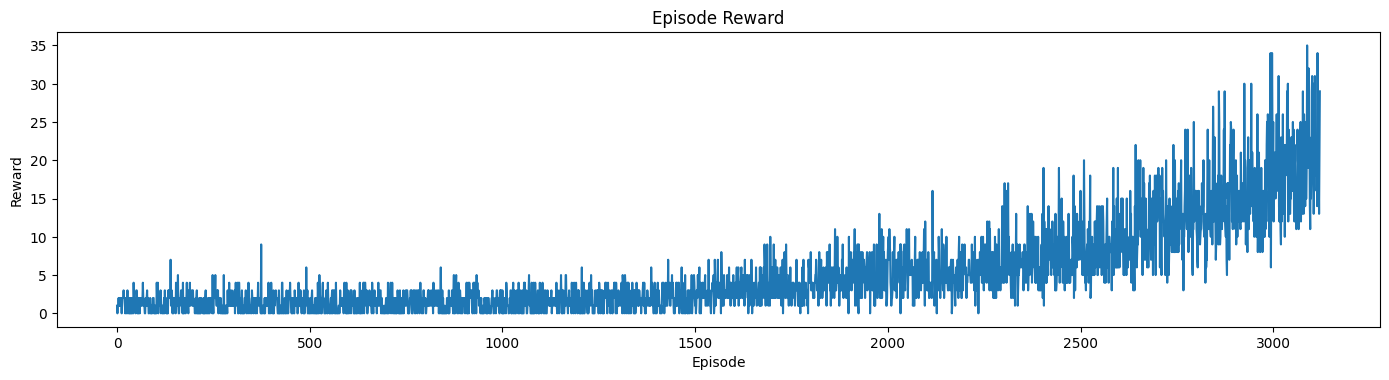

In [15]:
# visualisation de la performance
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history['episode_reward'])
plt.title('Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.tight_layout()
plt.savefig('training_performance.png')
plt.show()

## 7. Test

* Création d'un env de test
* application du prétraitement à l'env
* test sur 10 épisodes avec visualisation
* Affichage du score moyen sur les 10 épisodes

In [20]:
test_env = gym.make('ALE/Breakout-v5', render_mode='human')
test_env = AtariPreprocessing(test_env,
                              screen_size=84,
                              grayscale_obs=True,
                              frame_skip=1,
                              noop_max=30)
test_env = CompatibilityWrapper(test_env)

class RenderWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env

    def render(self, *args, **kwargs):
        return self.env.render()  # Ignorer les arguments mode

test_env = RenderWrapper(test_env)

scores = dqn.test(test_env,
                  nb_episodes=10,
                  visualize=True)
print('Average score over 10 test episodes:',
      np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...


C:\Users\33626\anaconda3\envs\deep\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Episode 1: reward: 15.000, steps: 642
Episode 2: reward: 33.000, steps: 1208
Episode 3: reward: 29.000, steps: 1209
Episode 4: reward: 25.000, steps: 1017
Episode 5: reward: 26.000, steps: 1038
Episode 6: reward: 22.000, steps: 840
Episode 7: reward: 22.000, steps: 800
Episode 8: reward: 19.000, steps: 765
Episode 9: reward: 30.000, steps: 1162
Episode 10: reward: 27.000, steps: 1085
Average score over 10 test episodes: 24.8


## 8. Clore l'environnement

In [ ]:
env.close()